# Extract Corresponded Part of different elementary map

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

class ImageSegmenter:
    def __init__(self, json_path, image_paths):
        self.masks = self.load_masks_from_json(json_path)
        self.image_paths = image_paths
    
    def load_masks_from_json(self, json_path):
        """
        Load masks from a JSON file and convert them to numpy arrays.
        """
        with open(json_path, 'r', encoding='utf-8') as file:
            masks = json.load(file)
       
        # Convert segmentation lists back to numpy arrays
        for mask in masks:
            mask['segmentation'] = np.array(mask['segmentation'])
       
        return masks
    
    def extract_bounding_box(self, mask):
        """
        Extract the bounding box of the segmented region in the mask.
        """
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        y_min, y_max = np.where(rows)[0][[0, -1]]
        x_min, x_max = np.where(cols)[0][[0, -1]]
       
        return x_min, y_min, x_max, y_max
    
    def crop_image_around_bbox(self, image, bbox, size=224):
        """
        Crop the image around the bounding box to the specified size with smart centering.
        """
        x_min, y_min, x_max, y_max = bbox
        
        # Calculate object dimensions
        object_width = x_max - x_min
        object_height = y_max - y_min
        
        # Add padding to prevent cutoff (10% of object size)
        padding_factor = 0.1
        width_padding = int(object_width * padding_factor)
        height_padding = int(object_height * padding_factor)
        
        # Expand bounding box with padding, but keep within image bounds
        padded_x_min = max(0, x_min - width_padding)
        padded_y_min = max(0, y_min - height_padding)
        padded_x_max = min(image.shape[1], x_max + width_padding)
        padded_y_max = min(image.shape[0], y_max + height_padding)
        
        # Crop to padded bounding box
        cropped_image = image[padded_y_min:padded_y_max, padded_x_min:padded_x_max]
        
        # Convert to PIL for smart resizing
        pil_image = Image.fromarray(cropped_image.astype(np.uint8))
        
        # Calculate aspect ratio
        cropped_height, cropped_width = cropped_image.shape[:2]
        aspect_ratio = cropped_width / cropped_height
        
        # Determine new size while maintaining aspect ratio
        if aspect_ratio > 1:
            # Object is wider than tall
            new_width = size
            new_height = int(size / aspect_ratio)
        else:
            # Object is taller than wide
            new_height = size
            new_width = int(size * aspect_ratio)
        
        # Resize maintaining aspect ratio
        resized_image = pil_image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Calculate padding to center the object
        delta_w = size - new_width
        delta_h = size - new_height
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        
        # Pad to center the object in size x size frame
        final_image = ImageOps.expand(resized_image, padding, fill=(0, 0, 0))
        
        # Convert back to numpy array
        return np.array(final_image)
    
    def extract_segment_from_images(self, mask_index):
        """
        Extract the segment of the mask_index from all the provided images.
        """
        segmentation_mask = self.masks[mask_index]['segmentation']
        bbox = self.extract_bounding_box(segmentation_mask)
        segments = []
        
        for image_path in self.image_paths:
            image = Image.open(image_path)
            image_np = np.array(image)
            segment = image_np * np.expand_dims(segmentation_mask, axis=-1)
            cropped_segment = self.crop_image_around_bbox(segment, bbox)
            segments.append(cropped_segment)
        
        return segments
    
    def display_segments(self, segments):
        """
        Display the extracted segments from the images.
        """
        fig, axs = plt.subplots(1, len(segments), figsize=(15, 5))
        for ax, segment, image_path in zip(axs, segments, self.image_paths):
            ax.imshow(segment)
            ax.set_title(self.extract_image_name(image_path))
            ax.axis('off')
        plt.show()
    
    @staticmethod
    def extract_image_name(image_path):
        """
        Extract the meaningful part of the image name from the image path.
        """
        parts = image_path.split('/')[-1].split(' ')
        for i, part in enumerate(parts):
            if part == 'Map_aligned.png':
                return parts[i - 1]
        return "Unknown"

# Load Data

Take sometime to load the json file, be patient!

In [9]:
# Example usage:
image_paths = [
    'Aligned/USU-4183B 150-250 Elemental Map/USU-4183B 150-250 Elemental Map_aligned.png',
    'Aligned/USU-4183B 150-250 Elemental Map/USU-4183B 150-250 K Map_aligned.png',
    'Aligned/USU-4183B 150-250 Elemental Map/USU-4183B 150-250 Si Map_aligned.png',
    'Aligned/USU-4183B 150-250 Elemental Map/USU-4183B 150-250 Na Map_aligned.png',
    'Aligned/USU-4183B 150-250 Elemental Map/USU-4183B 150-250 Ca Map_aligned.png',
    'Aligned/USU-4183B 150-250 Elemental Map/USU-4183B 150-250 Al Map_aligned.png'
]

json_path = 'Seg_Images/USU-4183B 150-250 Elemental Map_aligned/USU-4183B 150-250 Elemental Map_aligned.json'

# Create an instance of the ImageSegmenter class
segmenter = ImageSegmenter(json_path, image_paths)

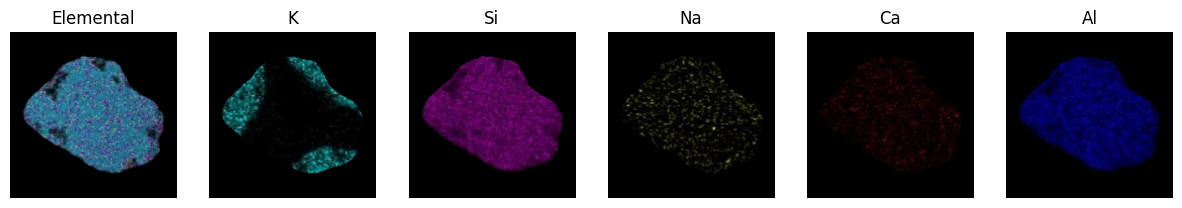

In [10]:
# Specify the mask index you want to retrieve
mask_index = 66  # Change this to the desired mask index

# Extract the segment from all the images
segments = segmenter.extract_segment_from_images(mask_index)

# Display the extracted segments
segmenter.display_segments(segments)

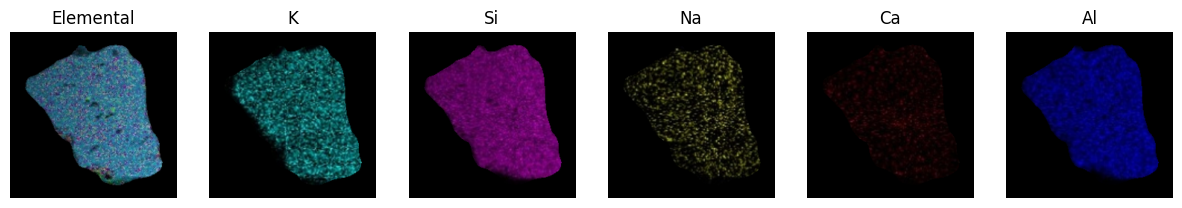

In [12]:
# Specify the mask index you want to retrieve
mask_index = 69  # Change this to the desired mask index

# Extract the segment from all the images
segments = segmenter.extract_segment_from_images(mask_index)

# Display the extracted segments
segmenter.display_segments(segments)

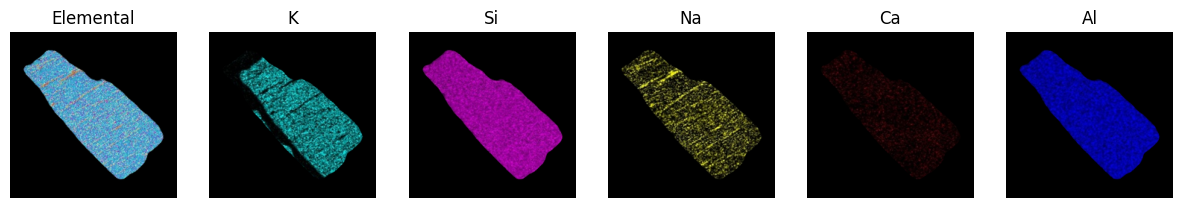

In [11]:
# Specify the mask index you want to retrieve
mask_index = 70  # Change this to the desired mask index

# Extract the segment from all the images
segments = segmenter.extract_segment_from_images(mask_index)

# Display the extracted segments
segmenter.display_segments(segments)